# Extracting Spectra

This notebook demonstrates how to grab 1D aperture summed HETDEX spectra for an input of ID, RA and DEC using the `Extract` Class API from `hetdex_api`. This can be done interactively using `get_spectra` from hte `hetdex_tools.get_spec` module. It can also be done in the command line using the quick entry call `hetdex_get_spec` providing you have hetdex_api pip installed.

Examples of what you might like to do with the spectra afterwards is shown later. The output is stored in an astropy table of spectra. For every HETDEX observation where spectra is found, a spectra is given. It is up to the user to combine the spectra afterwards.

### IMPORTANT NOTE OF CAUTION WITH RUNNING ON TACC!!!

Because this script involves opening the Fibers class object which contains all fiber spectra from a 3 dither observation, you will be pulling in a lot of memory for each shot that is open. **NEVER** run this script from a login node on TACC. A login node is a node you access when you ssh in. 

You need to request a compute node instead by either 

(1) using the idev command : `idev -t 04:00:00` 

(2) using a jupyter notebook 

(3) or by submitting the job into the slurm job scheduler (this is probably only needed if you are doing more than 1000 extractions per shot on more than 1000 shots)

### Import all necessary python packages. 
These are mainly for working within the notebook. The command line tool already has the necessary preamble built in.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table, join

from hetdex_tools.get_spec import get_spectra

## Getting all spectra at a specified RA/DEC. This will search through all shots in HDR2

If a shotid is not specified the program will search for any shot within HDR2 that overlaps within an 11 arcmin radius of the input coordinates. Because of the non-contiguous VIRUS footprint, there is no guarantee the aperture defined by the input ra/dec/rad will contain enough fibers to do a measurement. The aperture radius is 3" by default or can be specified with the --rad argument. 

Open a catalog of IDs, RAs, DECs:

In [2]:
input_cat = Table.read('/work/05350/ecooper/stampede2/hdr2-tests/hps-muse/highz_emitters.fits')

In [3]:
input_cat[0:5]

ID,RA,DEC,WAVE,FLUX,FLUXE_L,FLUXE_H,z
,deg,deg,Angstrom,1e-17 erg / (cm2 s),1e-17 erg / (cm2 s),1e-17 erg / (cm2 s),
int64,float64,float64,float64,float64,float64,float64,float64
3,35.30979166666667,-4.527130555555556,4973.93,19.9,3.1,4.7,3.0915
4,35.31191666666666,-4.532388888888889,5261.37,42.6,12.4,11.2,1.7561
5,35.31308333333333,-4.531666666666666,4270.67,342.1,14.3,16.5,1.757
6,35.31816666666666,-4.4926,4591.58,32.7,3.6,3.5,2.777
11,35.32691666666666,-4.459319444444445,4590.82,21.2,4.6,4.7,2.7764


`get_spectra()` requires an astropy coordinates object list as an input.

In [4]:
input_coords = SkyCoord(ra=input_cat['RA'], dec=input_cat['DEC'])

In [7]:
sources = get_spectra(input_coords, ID=input_cat['ID'])

##  get_spectra() options

There are a few options to consider when running get_spectra():

In [6]:
help(get_spectra)

Help on function get_spectra in module hetdex_tools.get_spec:

get_spectra(coords, ID=None, rad=3.0, multiprocess=True, shotid=None, survey='hdr2', tpmin=0.09, ffsky=False)
    Function to retrieve PSF-weighted, ADR and aperture corrected
    spectral extractions of HETDEX fibers. It will search all shots
    within a specific HETDEX Data Release and return a table of
    spectra for each extraction per shot in which more than 7 fibers
    are found in order to generate an extracted spectrum.
    
    Parameters
    ----------
    coords
        list astropy coordinates
    ID
        list of ID names (must be same length as coords). Will
        generate a running index if no ID is given
    rad
        radius of circular aperture to be extracted in arcsec.
        Default is 3.0
    multiprocess
        boolean flag to use multiprocessing. This will greatly
        speed up its operation as it will extract on 32 shots at
        time. But only use this when on a compute node. Use
   

### Reading in the output - astropy FITS files

In [9]:
sources[0:5]

ID,shotid,wavelength [1036],spec [1036],spec_err [1036],weights [1036]
,,Angstrom,1e-17 erg / (Angstrom cm2 s),1e-17 erg / (Angstrom cm2 s),
int64,int64,float64,float64,float64,float64
360,20170130027,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.8530224046204286 .. 0.8566766913047349
360,20170224006,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.8502338248829885 .. 0.8602435340384444
360,20170326010,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.8750953493900122 .. 0.8787945903307385
372,20170126002,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.8811780092325096 .. 0.8900289027924926
372,20170322016,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.8997470730626222 .. 0.9202416808656538


Join your input and output table so you can match up any properties you like

In [10]:
output_table = join(input_cat, sources)

In [11]:
output_table[0:5]

ID,RA,DEC,WAVE,FLUX,FLUXE_L,FLUXE_H,z,shotid,wavelength [1036],spec [1036],spec_err [1036],weights [1036]
,deg,deg,Angstrom,1e-17 erg / (cm2 s),1e-17 erg / (cm2 s),1e-17 erg / (cm2 s),,,Angstrom,1e-17 erg / (Angstrom cm2 s),1e-17 erg / (Angstrom cm2 s),
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
182,150.05175,2.2376444444444443,4174.25,25.6,5.2,5.8,2.4337,20170222007,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.8779764074573124 .. 0.8919157194039836
182,150.05175,2.2376444444444443,4174.25,25.6,5.2,5.8,2.4337,20170202003,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.9882423520354104 .. 0.9140588857024189
189,150.05504166666665,2.31525,4195.93,12.9,6.7,8.7,2.4515,20170331006,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.8342767868348164 .. 0.6895230963441078
194,150.05908333333332,2.2405861111111114,3997.41,61.0,4.3,4.9,2.2882,20181117010,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.8559235841764234 .. 0.794577504985113
194,150.05908333333332,2.2405861111111114,3997.41,61.0,4.3,4.9,2.2882,20181114020,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.8211261682267719 .. 0.730172296780675


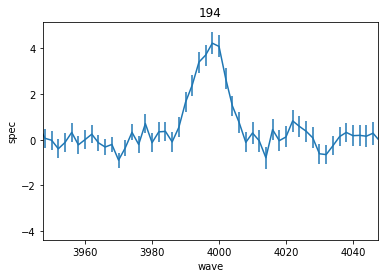

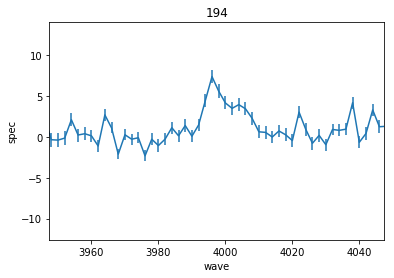

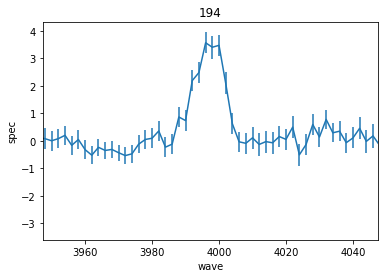

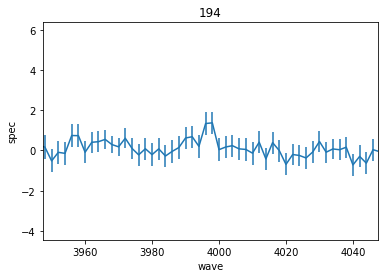

In [12]:
sel = output_table['FLUX'] > 10

for row in output_table[sel][4:8]:
    plt.figure()
    wave_obj = row['WAVE']
    wave = row['wavelength']
    spec = row['spec']
    spec_err = row['spec_err']
    plt.errorbar(wave, spec, yerr=spec_err)
    plt.xlim(wave_obj-50, wave_obj+50)
    plt.xlabel('wave')
    plt.ylabel('spec')
    plt.title(row['ID'])


### Examples of running get_spec as a command line job:


You can run these commands from the command line by removing the "!" command but be sure you are on a compute node by calling `idev` first or submitting these as slurm jobs, one task per line.

In [12]:
!hetdex_get_spec --ra 150.02548 --dec 2.087987 --ID cosmos_LAE --outfile cosmos_LAE

### Speed things up using multiprocessing

You can speed up processes (by up to ~30x) with python multiprocessing if you are working interactively in a notebook or in an idev session (**NEVER FROM A LOGIN NODE**). Use the multiprocessing option with the argument -mp True or --multiprocess True 

In [ ]:
!hetdex_get_spec --multiprocess -ra 150.02548 -dec 2.087987 -id mptest -o mptest

### Save output as individual astropy tables for each ID/shot combination:

If you prefer to save each spectra to a table, you can do this. We don't recommend this for large numbers of data, but understand that sometimes its easy to start with a readable table. The tables will be stored in the files named `spec_[ID]_[shotid].tab`

In [ ]:
!hetdex_get_spec  --multiprocess --single -ra 150.02548 -dec 2.087987 -id cosmos_lae

### Getting all spectra at a specified RA/DEC in a specific OBSERVATION/SHOT

Perhaps you only want to focus on a specific shot. Then you can use the -s argument to put the shotid either as an interger value 'YYYYMMDDOBS'= 20190104008 or as a str '20190104v009'. Note if you don't give an --ID option the default is 'DEX'

This is a command line routine so remove the "!" if you are running in a terminal.

In [ ]:
!hetdex_get_spec  -ra 8.86535 -dec 0.59352  -s 20190104008 -o 20190104008

This is particularly helpful if you plan to submit each shot as a separate task. For this reason, I suggest changing the default --outfile option to -o 20190104008 to create the output fits file 20190104008.fits

### Work on a list of ID/RA/DECs

This can either be a saved astropy table, or an space delimited text file with 3 columns where the columns are ID, RA, DEC. If you want more functionality with your input catalog, just talk to Erin. Note that running this job will take about 30 minutes so only execute if you want to wait around to explore the output.

In [ ]:
!cp /work/05350/ecooper/stampede2/3dhst/3dhst_input.cat .

In [ ]:
!hetdex_get_spec  --multiprocess -i '3dhst_input.cat' -o '3dhst'